In [1]:
%matplotlib inline 
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time 
from tqdm import tqdm
import seaborn as sns
import operator 
import sys 
from path_overlap import * 

In [2]:
import numpy as np
from scipy.optimize import minimize, basinhopping

In [3]:
import numpy as np

import sys


def MRT(rr, cover_item, const=.4, epsilon=0.001): 
    n = len(cover_item);
    return  epsilon + const *  (1 - (n+1)*(1-rr)/n) * np.log(n*n*rr/(1-rr)) 

def reconf_cost(n_prev, n_next=0, nonlin=1, norm_factor=1):
    if n_next != None:
        return ((n_prev * n_next) ** nonlin) / norm_factor
    else:
        return 1 / norm_factor


def tot_reconf_cost(cover, nonlin=0.5, norm_factor=1, log=True):
    accrued_cost = 0
    for step in range(len(cover)):
        if step == len(cover) - 1:
            accrued_cost += reconf_cost(len(cover[step]), nonlin, norm_factor)
        else:
            accrued_cost += reconf_cost(
                len(cover[step]), len(cover[step + 1]), nonlin, norm_factor
            )
    if log == True:
        return np.log(accrued_cost)
    else:
        return accrued_cost


def new_strong_weak_graph(
    num_layers,
    num_dense,
    num_sparse,
    weak_density,
    strong_mu,
    strong_std,
    weak_mu,
    weak_std,
    frac=0.8,
):
    tot_units = num_dense + num_sparse
    G = multipartite_network(num_layers, num_dense, num_sparse, 0.0)
    rel_dict = dict(zip(G.nodes(), range(G.number_of_nodes())))
    inv_rel_dict = dict(zip(range(G.number_of_nodes()), G.nodes()))

    G = nx.relabel_nodes(G, rel_dict)
    strong_w = np.random.normal(strong_mu, strong_std, G.number_of_edges())
    nx.set_edge_attributes(G, dict(zip(G.edges(), strong_w)), "weight")
    strong_paths = []
    for s in range(tot_units):
        for t in range((num_layers - 1) * tot_units, (num_layers) * tot_units):
            strong_paths.extend(nx.all_simple_paths(G, s, t))

    Gr = multipartite_network(num_layers, num_dense + num_sparse, 0, weak_density)
    Gr = rewire_multipartite_network(
        Gr, tot_units, 1, rewire_iters=int(frac * Gr.number_of_edges())
    )
    Gr = nx.relabel_nodes(Gr, rel_dict)
    weak_mu, weak_std = 1, 0.2
    weak_w = np.random.normal(weak_mu, weak_std, Gr.number_of_edges())
    weak_w_dict = dict(zip(Gr.edges(), weak_w))
    for edge in Gr.edges():
        if not G.has_edge(edge[0], edge[1]):
            G.add_edge(edge[0], edge[1], weight=weak_w_dict[edge])
    del Gr
    weak_paths = []
    for s in range(tot_units):
        for t in range((num_layers - 1) * tot_units, (num_layers) * tot_units):
            weak_paths.extend(nx.all_simple_paths(G, s, t))

    for path in strong_paths:
        if path in weak_paths:
            weak_paths.remove(path)
    return G, strong_paths, weak_paths


def subgraph_relabel(gg, ts, dic=False):
    nn = []
    for t in ts:
        nn.extend(t)
        nn = list(set(nn))
    sg = nx.subgraph(gg, nn)
    rel_dict = dict(zip(sg.nodes(), list(range(sg.number_of_nodes()))))
    sg = nx.relabel_nodes(sg, rel_dict)
    new_ts = []
    for t in ts:
        new_ts.append([rel_dict[x] for x in t])
    if dic == False:
        return sg, new_ts
    else:
        return sg, new_ts, rel_dict


def are_structural_interfering(p1, p2):
    if set(p1[1:]).intersection(set(p2[1:])):
        return True
    else:
        return False


def multitask_subgraph(g, paths):
    nodes = []
    for t in paths:
        nodes.extend(t)
    nodes = list(set(nodes))
    return nx.subgraph(g, nodes)


def are_functionally_interfering(g, paths):  # beware it works only for two tasks
    if are_structural_interfering(*paths):
        return False
    ms = multitask_subgraph(nx.Graph(g), paths)
    if nx.number_connected_components(ms) == len(paths):
        return False
    else:
        return True


def single_task_in_multitask_prob(
    t, sg, betas_t, nus, weight_func=np.exp, attr="capacity", verbose=False
):
    prob = 1
    w = nx.get_edge_attributes(sg, attr)
    for i, n in enumerate(t[1:]):
        # probability of propagating the right path
        in_n = list(sg.predecessors(n))
        predecessor_probs = []
        Z = weight_func(betas_t[n]) + np.sum(
            [
                weight_func(w[(x, n)] ** nus[n])
                for x in in_n
                if sg.in_degree(x) > 0 or x == t[0]
            ]
        )
        prob *= weight_func(w[(t[i], n)] ** nus[n]) / Z
    return prob


def compute_multitask_interference(gg, tl, nl, b, nu):
    probs = []
    for t in tl:
        probs.append(
            single_task_in_multitask_prob(
                t, gg, b, nu, weight_func=np.exp, attr="weight"
            )
        )
    return probs


def objective_fun_multitask(x):
    n = int(len(x) / 2)
    probs = compute_multitask_interference(sg, new_tasks, num_layers, x[:n], x[n:])
    compound_prob = 1
    for prob in probs:
        compound_prob *= prob
    if compound_prob != 0:
        return -np.log(compound_prob)
    else:
        return 0


def local_full_rr(rrs, cover,  mrt_const=1, nonlin=1, norm_factor=1):
    cv = [cover[1]]
    tot_cost = 1;
    s = 0;
    for i, rr in enumerate(rrs):
        tot_cost *= rr;
        s += MRT(rr, cover[i])
    rc = tot_reconf_cost(cv, nonlin, norm_factor, log=False);

    return [np.round(x,3) for x in [tot_cost/s, tot_cost, s, rc, tot_cost/(s+rc)]];


def report_interference_patterns(gg, ts):
    rep = []
    for comb in combinations(range(3), 2):
        rep.append(
            [
                comb,
                are_structural_interfering(*[ts[x] for x in comb]),
                are_functionally_interfering(gg, [ts[x] for x in comb]),
            ]
        )
    return rep

In [4]:

def update_path_weight(g0, factor, path):
    gt = nx.DiGraph(g0);
    for i in range(len(path)-1):
        gt[path[i]][path[i + 1]]["weight"] = factor*g0[path[i]][path[i + 1]]["weight"]
    return gt;

def eps_noise(scale=0.5):
    return np.random.random() * scale;


# Reward optimization 

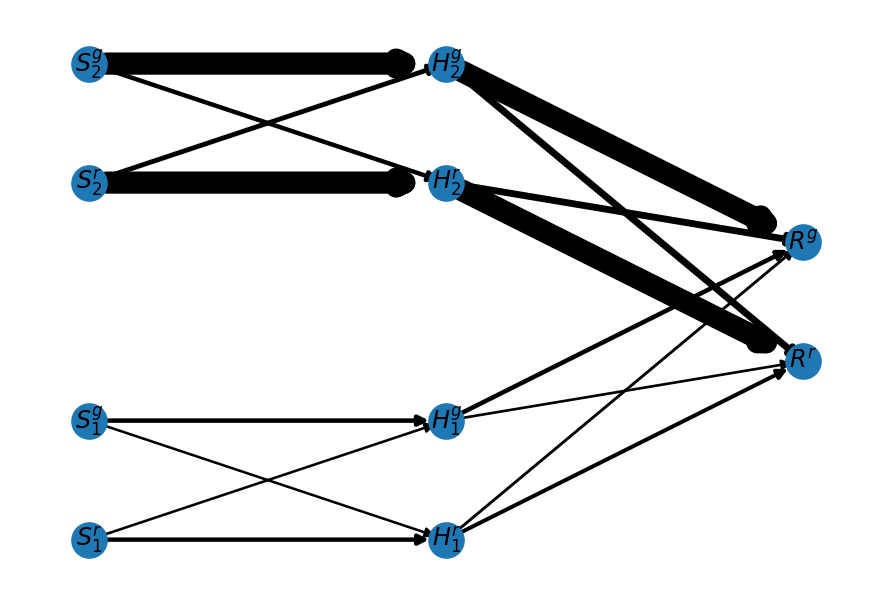

In [7]:

nodes = [r'$S_1^r$',r'$S_1^g$', r'$S_2^r$', r'$S_2^g$', r'$H_1^r$', r'$H_1^g$', r'$H_2^r$', r'$H_2^g$', r'$R^r$', r'$R^g$']

beta = 10
betas  = [0, 0, 0, 0, 
          beta, beta, beta, beta, 
         beta, beta]


pos = [(0, 0), (0, 1), (0, 3), (0, 4),
      (1, 0), (1, 1), (1, 3), (1, 4),
      (2, 1.5), (2, 2.5)]

betas = dict(zip(nodes,betas))
pos = dict(zip(nodes,pos))


w_strong = 6
w_medium = 2
w_weak = 1.5 


G2 = nx.DiGraph()
G2.add_nodes_from(nodes)
nx.set_node_attributes(G2, betas, 'beta')
factor = 1.8

#input-representation links
G2.add_edge(r'$S_1^r$',r'$H_1^r$', weight=w_medium + eps_noise()) ### mediuim
G2.add_edge(r'$S_1^g$',r'$H_1^g$', weight=w_medium + eps_noise())
G2.add_edge(r'$S_2^r$',r'$H_2^r$', weight=factor*w_strong + eps_noise())
G2.add_edge(r'$S_2^g$',r'$H_2^g$', weight=factor*w_strong + eps_noise())

# #input cross links
G2.add_edge(r'$S_1^r$',r'$H_1^g$', weight=-w_weak + eps_noise())
G2.add_edge(r'$S_1^g$',r'$H_1^r$', weight=-w_weak + eps_noise())
G2.add_edge(r'$S_2^r$',r'$H_2^g$', weight=-factor*w_weak + eps_noise())
G2.add_edge(r'$S_2^g$',r'$H_2^r$', weight=-factor*w_weak + eps_noise())

#representation-output links
#color naming
G2.add_edge(r'$H_1^r$', r'$R^r$', weight=w_medium + eps_noise())
G2.add_edge(r'$H_1^g$', r'$R^g$', weight=w_medium + eps_noise())
G2.add_edge(r'$H_1^r$', r'$R^g$', weight=-w_weak + eps_noise())
G2.add_edge(r'$H_1^g$','$R^r$', weight=-w_weak + eps_noise())
#word reading
G2.add_edge(r'$H_2^r$', r'$R^r$', weight=factor*w_strong + eps_noise())
G2.add_edge(r'$H_2^g$', r'$R^g$', weight=factor*w_strong + eps_noise())
G2.add_edge(r'$H_2^r$', r'$R^g$', weight=-factor*w_medium + eps_noise())
G2.add_edge(r'$H_2^g$', r'$R^r$', weight=-factor*w_medium + eps_noise())
edges = G2.edges()
weights = [G2[u][v]['weight'] for u,v in edges]


nx.draw(G2, pos=pos, width=weights)
nx.draw_networkx_labels(G2, pos, verticalalignment='center', horizontalalignment='center');


In [8]:
results_collection = {}

In [79]:
G = nx.DiGraph()

G.add_edge('S1', 'H1', weight = w_strong + eps_noise())
G.add_edge('H1', 'R1', weight = w_strong + eps_noise())

G.add_edge('S2', 'H2', weight = factor*w_strong + eps_noise())
G.add_edge('H2', 'R1', weight = w_strong + eps_noise())
G.add_edge('H2', 'R2', weight = factor*w_strong + eps_noise())

G.add_edge('S2', 'H3', weight = w_weak + eps_noise())
G.add_edge('H3', 'R2', weight = w_weak + eps_noise())

In [80]:
G.edges()

OutEdgeView([('S1', 'H1'), ('H1', 'R1'), ('S2', 'H2'), ('S2', 'H3'), ('H2', 'R1'), ('H2', 'R2'), ('H3', 'R2')])

In [11]:
di_pos_coords = [(0, 0), (0, 1), (0, 2), 
          (1, 0), (1, 1), (1, 2), 
          (2, 1)]

di_pos = dict(zip(G.nodes(), di_pos_coords))
di_pos

{'S1': (0, 0),
 'H1': (0, 1),
 'R1': (0, 2),
 'S2': (1, 0),
 'H2': (1, 1),
 'R2': (1, 2),
 'H3': (2, 1)}

/var/folders/bh/0ngr808d52sg9hxwrvf2hgd80000gn/T/ipykernel_84970/325880111.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


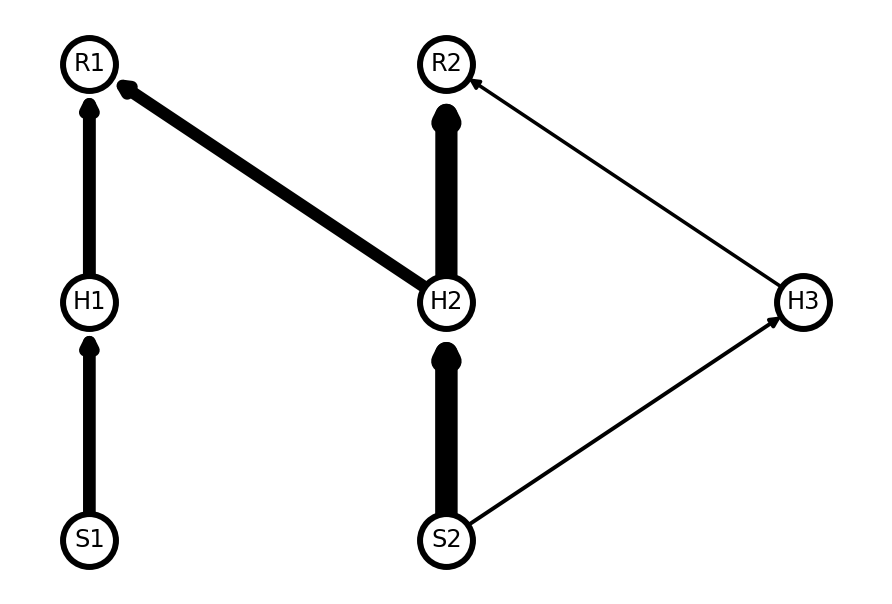

In [13]:
weights = [G[u][v]['weight'] for u,v in G.edges]
nx.draw(G, pos=di_pos, width=np.abs(weights), 
        node_color='white',
        node_size = 700,
        edgecolors='black',
        linewidths=3);


nx.draw_networkx_labels(G, di_pos, 
                        verticalalignment='center', 
                        horizontalalignment='center', 
                       font_weight='30');
plt.tight_layout()


In [15]:
G = nx.relabel_nodes(G, dict(zip(G.nodes(), range(G.number_of_nodes()))))

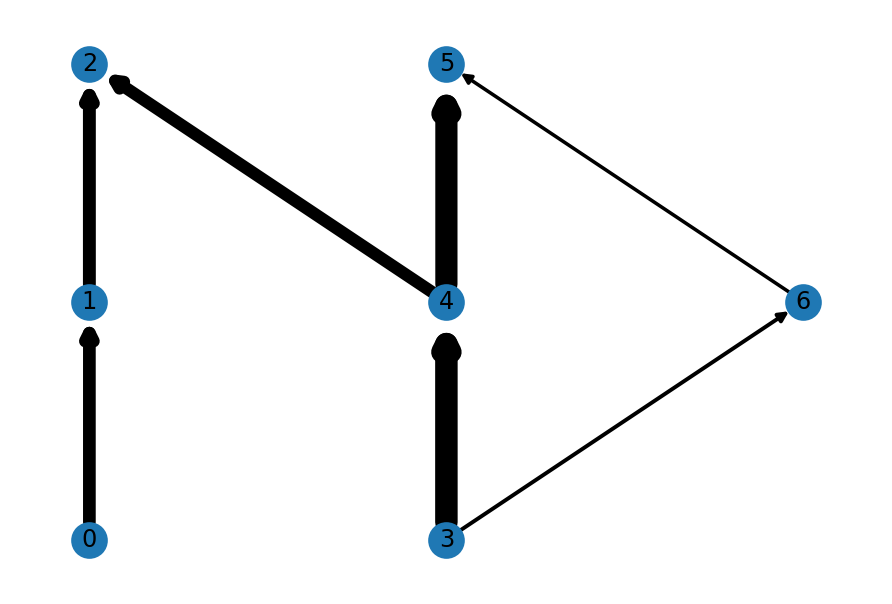

In [16]:
weights = [G[u][v]['weight'] for u,v in G.edges]
di_pos = dict(zip(G.nodes(), di_pos_coords))
di_pos

nx.draw(G, pos=di_pos, width=weights)
nx.draw_networkx_labels(G, di_pos, verticalalignment='center', horizontalalignment='center');

In [17]:
beta, nu0 = 1.49, 1


classic_paths = [
    [0, 1, 2],
    [3, 4, 5],
]

new_path = [3,6,5]
classic_nodes = list(classic_paths[0])
classic_nodes.extend(classic_paths[1])
classic_nodes

[0, 1, 2, 3, 4, 5]

In [18]:
classic_nodes, classic_paths

([0, 1, 2, 3, 4, 5], [[0, 1, 2], [3, 4, 5]])

In [21]:
G_t = update_path_weight(G, factor, new_path)
list(zip(G_t.edges(data=True), G.edges(data=True)))

[((0, 1, {'weight': 6.350816911135614}),
  (0, 1, {'weight': 6.350816911135614})),
 ((1, 2, {'weight': 6.445065326710559}),
  (1, 2, {'weight': 6.445065326710559})),
 ((3, 4, {'weight': 11.249263349017022}),
  (3, 4, {'weight': 11.249263349017022})),
 ((3, 6, {'weight': 3.5310488573599765}),
  (3, 6, {'weight': 1.9616938096444314})),
 ((4, 2, {'weight': 6.107581171039813}),
  (4, 2, {'weight': 6.107581171039813})),
 ((4, 5, {'weight': 11.104387729245513}),
  (4, 5, {'weight': 11.104387729245513})),
 ((6, 5, {'weight': 3.1887768819896682}),
  (6, 5, {'weight': 1.7715427122164824}))]

In [24]:
possible_covers = [
#     [[0, 1, 2]],
#     [[0], [1, 2]],
    [[1], [0, 2]],
    [[2], [0, 1]],
#     [[0], [1], [2]],
]


restricted_covers = [
    [[1], [0, 2]],
    [[2], [0, 1]],
    [[0], [1]],
    [[1], [0]]
]


beta, nu0 = 30, 1
min_beta = 0 * beta
num_layers = 3
perc = .2
beta_bounds_i = (min_beta, beta+0.001)
nu_bounds_i = (nu0-perc, nu0+perc)
# mrt_const = 0.1
mrt_value = .1
non_lin_value = 1
rounding = 50
learning_rate = 0.0002

In [26]:
from collections import defaultdict

In [27]:
tag = -1

all_paths = list(classic_paths)
all_paths.append(new_path) 
actual_tasks = all_paths
full_record = defaultdict(dict)

sgs = []

tracking = {}
for t in tqdm(range(1, 2500)):
    factor = learning_rate * t;
    
    G_t = update_path_weight(G, factor, new_path)

    time_covers = {}
    serialization_possibilities = {}
    sols = {}
    for cover in restricted_covers:
        rrs = []
        sols[str(cover)] = {}
        for subset in cover[1:]:
            tasks = [actual_tasks[c] for c in subset]
            print(cover, subset, tasks)
            sg, new_tasks, rl  = subgraph_relabel(G_t, tasks, True)
            sgs.append([subset, sg, rl]);
            inv_rl = dict(zip(rl.values(), rl.keys()))
            beta_vec = [beta] * sg.number_of_nodes()
            nu_vec = [nu0] * sg.number_of_nodes()

            x = beta_vec.copy()
            bnds = [beta_bounds_i] * len(beta_vec)
            x.extend(nu_vec)
            bnds.extend([nu_bounds_i] * len(nu_vec))
            bnds = tuple(bnds)

            from scipy.optimize import NonlinearConstraint

            sol = minimize(
                objective_fun_multitask, x, method="SLSQP", bounds=bnds
            )  
            probs = compute_multitask_interference(
                sg,
                list(new_tasks),
                num_layers,
                sol.x[: sg.number_of_nodes()],
                sol.x[sg.number_of_nodes() :],
            )
            compound_prob = 1
            for prob in probs:
                compound_prob *= prob
            rrs.append(compound_prob)
            sols[str(cover)][str(subset)] = sol.x
            
        time_covers[str(cover)] = local_full_rr(rrs, cover, mrt_const=mrt_value, nonlin=non_lin_value, norm_factor=.5)
        serialization_possibilities[str(cover)] = local_full_rr(
            rrs, cover, mrt_const=mrt_value, nonlin=non_lin_value, norm_factor=1
        ) 
        full_record[t][str(cover)] = time_covers[str(cover)]
        print(str(cover), time_covers[str(cover)])

    max_key = max(serialization_possibilities.items(), key=operator.itemgetter(1))[
        0
    ]
    tracking[t] = [max_key, [np.round(x, rounding) for x in time_covers[str(max_key)]]] 
    
    print('factor:', np.round(factor, rounding), 'cover:', str(max_key), [np.round(x, rounding) for x in time_covers[str(max_key)]])
    print('beta sols:', sols[max_key])
    print('\n')


  0%|          | 0/2499 [00:00<?, ?it/s]

[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [1.139, 0.25, 0.22, 1.414, 0.153]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.0002 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [1.143, 0.251, 0.219, 1.414, 0.153]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.0004 cover: [[2], [0, 1]]

[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.010400000000000001 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [1.303, 0.261, 0.2, 1.414, 0.162]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.0106 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,


[[1], [0, 2]] [1.556, 0.274, 0.176, 1.414, 0.173]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.0286 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [1.559, 0.275, 0.176, 1.414, 0.173]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.028800000000000003 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414

[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.053000000000000005 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [1.936, 0.291, 0.15, 1.414, 0.186]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.053200000000000004 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1

[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.0636 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [2.12, 0.297, 0.14, 1.414, 0.191]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.06380000000000001 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])

[[1], [0, 2]] [2.474, 0.308, 0.125, 1.414, 0.2]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.082 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [2.478, 0.309, 0.125, 1.414, 0.201]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.08220000000000001 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.

[[1], [0, 2]] [3.352, 0.329, 0.098, 1.414, 0.218]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.1178 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [3.358, 0.329, 0.098, 1.414, 0.218]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.11800000000000001 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414,

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.122 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [3.482, 0.332, 0.095, 1.414, 0.22]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.1222 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1

[[1], [0, 2]] [3.642, 0.335, 0.092, 1.414, 0.222]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.1274 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [3.648, 0.335, 0.092, 1.414, 0.222]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.12760000000000002 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414,

[[1], [0, 2]] [3.81, 0.338, 0.089, 1.414, 0.225]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.1326 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [3.817, 0.338, 0.088, 1.414, 0.225]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.1328 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta s

[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.1544 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [4.628, 0.35, 0.076, 1.414, 0.235]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.15460000000000002 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01]

[[1], [0, 2]] [5.314, 0.358, 0.067, 1.414, 0.242]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.1698 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [5.323, 0.358, 0.067, 1.414, 0.242]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.17 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta so

[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.186 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [6.196, 0.367, 0.059, 1.414, 0.249]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.1862 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.2000

[[1], [0, 2]] [7.122, 0.374, 0.053, 1.414, 0.255]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.2006 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [7.136, 0.375, 0.052, 1.414, 0.255]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.2008 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta 

[[1], [0, 2]] [7.98, 0.38, 0.048, 1.414, 0.26]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.21200000000000002 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
beta sols: {'[0, 1]': array([3.00000000e+01, 3.84461787e-14, 2.51489959e-14, 3.00000000e+01,
       1.55823579e-01, 5.80814249e-02, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 9.53741494e-01, 9.50340197e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [7.996, 0.381, 0.048, 1.414, 0.26]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.2122 cover: [[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.4

[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.25720000000000004 cover: [[1], [0, 2]] [13.01, 0.404, 0.031, 1.414, 0.279]
beta sols: {'[0, 2]': array([3.00000000e+01, 2.56640760e-04, 9.22169809e-04, 3.00000000e+01,
       9.89536756e-16, 1.06541333e-15, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [13.041, 0.404, 0.031, 1.414, 0.279]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.2574 cover: [[1], [0, 2]] [13.041, 0.404, 0.031, 1.414, 0.279]
beta sols: {'[0, 2]': array([3.00000000e+01, 2.61763398e-04, 9.33182247e-04, 3.00000000e+01,
       3.02982647e-16, 2.60129730e-19, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-

[[1], [0, 2]] [15.297, 0.411, 0.027, 1.414, 0.285]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.27080000000000004 cover: [[1], [0, 2]] [15.297000000000002, 0.411, 0.027, 1.414, 0.285]
beta sols: {'[0, 2]': array([3.00000000e+01, 2.09998351e-04, 9.67514685e-04, 3.00000000e+01,
       3.09560207e-16, 3.48289861e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [15.335, 0.411, 0.027, 1.414, 0.285]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.271 cover: [[1], [0, 2]] [15.335, 0.411

[[1], [0, 2]] [17.82, 0.417, 0.023, 1.414, 0.29]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.28300000000000003 cover: [[1], [0, 2]] [17.82, 0.417, 0.023, 1.414, 0.29]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.62888721e-04, 9.88848580e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [17.866, 0.417, 0.023, 1.414, 0.29]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.2832 cover: [[1], [0, 2]] [17.866, 0.417, 0.023, 1.414, 

[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3018 cover: [[1], [0, 2]] [22.909, 0.426, 0.019, 1.414, 0.297]
beta sols: {'[0, 2]': array([3.00000000e+01, 7.43609869e-05, 9.14558032e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [22.973, 0.426, 0.019, 1.414, 0.297]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.302 cover: [[1], [0, 2]] [22.973, 0.426, 0.019, 1.414, 0.297]
beta sols: {'[0, 2]': array([3.00000000e+01, 7.34758923e-05, 9.13034410e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1],

[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [27.7, 0.433, 0.016, 1.414, 0.303]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.315 cover: [[1], [0, 2]] [27.7, 0.433, 0.016, 1.414, 0.303]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.66560559e-16, 7.77929144e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [27.783, 0.433, 0.016, 1.414, 0.303]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.31520000000000004 cover: 

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.319 cover: [[1], [0, 2]] [29.416, 0.435, 0.015, 1.414, 0.304]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.62074672e-16, 7.38470328e-04, 3.00000000e+01,
       0.00000000e+00, 2.91145120e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [29.505, 0.435, 0.015, 1.414, 0.304]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.31920000000000004 cover: [[1], [0, 2]] [29.505, 0.435, 0.015, 1.414, 0.304]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.36365528e-16, 7.36341153e-04, 3.00000

[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3216 cover: [[1], [0, 2]] [30.608, 0.436, 0.014, 1.414, 0.305]
beta sols: {'[0, 2]': array([3.00000000e+01, 2.74980776e-17, 7.07729398e-04, 3.00000000e+01,
       5.93727987e-18, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [30.702, 0.436, 0.014, 1.414, 0.305]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.32180000000000003 cover: [[1], [0, 2]] [30.702, 0.436, 0.014, 1.414, 0.305]
beta sols: {'[0, 2]': array([3.0000000e+01, 0.0000000e+00, 7.0512715e-04, 3.0000000e+01,
       0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.2000000e+00,
    

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3262 cover: [[1], [0, 2]] [32.881, 0.438, 0.013, 1.414, 0.307]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.81766494e-16, 6.56926288e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [32.985, 0.438, 0.013, 1.414, 0.307]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3264 cover: [[1], [0, 2]] [32.985, 0.438, 0.013, 1.414, 0.307]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 6.57417625e-04, 3.00000000e+01,
   

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.32980000000000004 cover: [[1], [0, 2]] [34.822, 0.44, 0.013, 1.414, 0.308]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 6.17947020e-04, 3.00000000e+01,
       0.00000000e+00, 3.21385721e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [34.934, 0.44, 0.013, 1.414, 0.308]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.33 cover: [[1], [0, 2]] [34.934, 0.44, 0.013, 1.414, 0.308]
beta sols: {'[0, 2]': array([3.00000000e+01, 7.16271389e-16, 6.16538348e-04, 3.00000000e

[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3326 cover: [[1], [0, 2]] [36.44, 0.441, 0.012, 1.414, 0.309]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 5.81915376e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [36.559, 0.441, 0.012, 1.414, 0.309]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.33280000000000004 cover: [[1], [0, 2]] [36.559, 0.441, 0.012, 1.414, 0.309]
beta sols: {'[0, 2]': array([3.00000000e+01, 6.90325076e-16, 5.82431688e-04, 3.00000000e+01,
       5.91622053e-16, 5.70049548e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.33840000000000003 cover: [[1], [0, 2]] [40.128, 0.444, 0.011, 1.414, 0.312]
beta sols: {'[0, 2]': array([3.00000000e+01, 9.09746095e-16, 5.13116514e-04, 3.00000000e+01,
       8.15565622e-16, 6.96899206e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [40.264, 0.444, 0.011, 1.414, 0.312]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3386 cover: [[1], [0, 2]] [40.264, 0.444, 0.011, 1.414, 0.312]
beta sols: {'[0, 2]': array([3.00000000e+01, 4.23877470e-16, 5.10000423e-04, 3.0000

[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3432 cover: [[1], [0, 2]] [43.57, 0.446, 0.01, 1.414, 0.313]
beta sols: {'[0, 2]': array([3.00000000e+01, 4.64379957e-16, 4.49501249e-04, 3.00000000e+01,
       4.33159375e-17, 4.56868548e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [43.722, 0.446, 0.01, 1.414, 0.313]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.34340000000000004 cover: [[1], [0, 2]] [43.722, 0.446, 0.01, 1.414, 0.313]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 4.46593434e-04, 3.00000000e+01,
       0.00000000e+00, 1.63261880e-16, 1.00000000e+00, 1.20000000e+00,


[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3482 cover: [[1], [0, 2]] [47.594, 0.449, 0.009, 1.414, 0.315]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 3.90958832e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [47.765, 0.449, 0.009, 1.414, 0.315]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.34840000000000004 cover: [[1], [0, 2]] [47.765, 0.449, 0.009, 1.414, 0.315]
beta sols: {'[0, 2]': array([3.00000000e+01, 6.36098219e-16, 3.83167517e-04, 3.0000

[[1], [0, 2]] [52.523, 0.451, 0.009, 1.414, 0.317]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3536 cover: [[1], [0, 2]] [52.523, 0.451, 0.009, 1.414, 0.317]
beta sols: {'[0, 2]': array([3.00000000e+01, 6.84344795e-16, 3.15739599e-04, 3.00000000e+01,
       5.95524335e-16, 6.48969051e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [52.718, 0.451, 0.009, 1.414, 0.317]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3538 cover: [[1], [0, 2]] [52.718, 0.451, 0.009, 1.414, 0.317]
b

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3562 cover: [[1], [0, 2]] [55.142, 0.453, 0.008, 1.414, 0.318]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 2.79465211e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [55.351, 0.453, 0.008, 1.414, 0.318]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3564 cover: [[1], [0, 2]] [55.351, 0.453, 0.008, 1.414, 0.318]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.58612752e-16, 2.75858224e-04, 3.00000000e+01,
   

[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [57.941, 0.454, 0.008, 1.414, 0.319]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3588 cover: [[1], [0, 2]] [57.941, 0.454, 0.008, 1.414, 0.319]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 2.34190018e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [58.164, 0.454, 0.008, 1.414, 0.319]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.35900000000000004 co

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.36160000000000003 cover: [[1], [0, 2]] [61.17199999999999, 0.455, 0.007, 1.414, 0.32]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.52353453e-16, 1.94512975e-04, 3.00000000e+01,
       1.52238759e-16, 1.88682959e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [61.412, 0.455, 0.007, 1.414, 0.32]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3618 cover: [[1], [0, 2]] [61.412, 0.455, 0.007, 1.414, 0.32]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.12321196e-15, 1.92311689e-04

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3642 cover: [[1], [0, 2]] [64.392, 0.456, 0.007, 1.414, 0.321]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 1.56133484e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [64.649, 0.457, 0.007, 1.414, 0.321]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3644 cover: [[1], [0, 2]] [64.649, 0.457, 0.007, 1.414, 0.321]
beta sols: {'[0, 2]': array([3.00000000e+01, 7.26399920e-16, 1.50891140e-04, 3.00000000e+01,
   

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3668 cover: [[1], [0, 2]] [67.843, 0.458, 0.007, 1.414, 0.322]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 1.13236417e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [68.119, 0.458, 0.007, 1.414, 0.322]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.367 cover: [[1], [0, 2]] [68.119, 0.458, 0.007, 1.414, 0.322]
beta sols: {'[0, 2]': array([3.00000000e+01, 5.83291640e-16, 1.10715607e-04, 3.00000000e+01,
    

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.36960000000000004 cover: [[1], [0, 2]] [71.842, 0.459, 0.006, 1.414, 0.323]
beta sols: {'[0, 2]': array([3.00000000e+01, 9.73050042e-16, 7.20671681e-05, 3.00000000e+01,
       2.36809411e-16, 6.72567686e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [72.14, 0.459, 0.006, 1.414, 0.323]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3698 cover: [[1], [0, 2]] [72.14, 0.459, 0.006, 1.414, 0.323]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.85404225e-16, 6.74553790e-05, 3.000000

[[1], [0, 2]] [76.161, 0.46, 0.006, 1.414, 0.324]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3724 cover: [[1], [0, 2]] [76.161, 0.46, 0.006, 1.414, 0.324]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 2.95236753e-05, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [76.483, 0.46, 0.006, 1.414, 0.324]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.37260000000000004 cover: [[1], [0, 2]] [76.483, 0.46, 0.006, 1.414,

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.375 cover: [[1], [0, 2]] [80.486, 0.462, 0.006, 1.414, 0.325]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.09120442e-16, 0.00000000e+00, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [80.832, 0.462, 0.006, 1.414, 0.325]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.37520000000000003 cover: [[1], [0, 2]] [80.832, 0.462, 0.006, 1.414, 0.325]
beta sols: {'[0, 2]': array([3.00000000e+01, 5.75377192e-16, 4.33308174e-16, 3.00000

[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3778 cover: [[1], [0, 2]] [85.515, 0.463, 0.005, 1.414, 0.326]
beta sols: {'[0, 2]': array([3.00000000e+01, 2.72684411e-16, 0.00000000e+00, 3.00000000e+01,
       0.00000000e+00, 4.39006221e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [85.89, 0.463, 0.005, 1.414, 0.326]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.378 cover: [[1], [0, 2]] [85.89, 0.463, 0.005, 1.414, 0.326]
beta sols: {'[0, 2]': array([30. ,  0. ,  0. , 30. ,  0. ,  0. ,  1. ,  1.2,  1.2,  1. ,  0.8,
        0.8])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [86.26

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3806 cover: [[1], [0, 2]] [90.967, 0.464, 0.005, 1.414, 0.327]
beta sols: {'[0, 2]': array([3.00000000e+01, 9.43212291e-17, 3.76904975e-16, 3.00000000e+01,
       4.13615897e-16, 4.87903025e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [91.373, 0.464, 0.005, 1.414, 0.327]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3808 cover: [[1], [0, 2]] [91.373, 0.464, 0.005, 1.414, 0.327]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 0.00000000e+00, 3.00000000e+01,
   

[[1], [0, 2]] [96.884, 0.466, 0.005, 1.414, 0.328]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3834 cover: [[1], [0, 2]] [96.884, 0.466, 0.005, 1.414, 0.328]
beta sols: {'[0, 2]': array([3.00000000e+01, 2.03903896e-16, 0.00000000e+00, 3.00000000e+01,
       0.00000000e+00, 2.51880306e-17, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [97.325, 0.466, 0.005, 1.414, 0.328]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3836 cover: [[1], [0, 2]] [97.325, 0.466, 0.005, 1.414, 0.328]
b

[[1], [0, 2]] [110.83, 0.468, 0.004, 1.414, 0.33]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.38920000000000005 cover: [[1], [0, 2]] [110.83, 0.4680000000000001, 0.004, 1.414, 0.33]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.74418707e-16, 2.80814534e-17, 3.00000000e+01,
       2.51731817e-16, 1.32444551e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [111.356, 0.468, 0.004, 1.414, 0.33]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3894 cover: [[1], [0, 2]] [111.356, 0.46

[[1], [0, 2]] [132.606, 0.472, 0.004, 1.414, 0.333]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3966 cover: [[1], [0, 2]] [132.606, 0.47200000000000003, 0.004, 1.414, 0.333]
beta sols: {'[0, 2]': array([30. ,  0. ,  0. , 30. ,  0. ,  0. ,  1. ,  1.2,  1.2,  1. ,  0.8,
        0.8])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [133.266, 0.472, 0.004, 1.414, 0.333]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.39680000000000004 cover: [[1], [0, 2]] [133.266, 0.47200000000000003, 0.004, 1.414, 0.333]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 3.50042963e-17, 3.0000

[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.3992 cover: [[1], [0, 2]] [141.522, 0.473, 0.003, 1.414, 0.334]
beta sols: {'[0, 2]': array([30. ,  0. ,  0. , 30. ,  0. ,  0. ,  1. ,  1.2,  1.2,  1. ,  0.8,
        0.8])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [142.238, 0.473, 0.003, 1.414, 0.334]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.39940000000000003 cover: [[1], [0, 2]] [142.238, 0.473, 0.003, 1.414, 0.334]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.89466638e-16, 1.05299748e-16, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [142.959, 0.473, 0.003, 1.414, 0.334]
[[2], [0, 1]] [0, 1

[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [203.013, 0.479, 0.002, 1.414, 0.338]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.41300000000000003 cover: [[1], [0, 2]] [203.013, 0.479, 0.002, 1.414, 0.338]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 2.08962589e-04, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [204.108, 0.479, 0.002, 1.414, 0.338]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.4132

[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.439 cover: [[1], [0, 2]] [396.058, 0.49099999999999994, 0.001, 1.414, 0.347]
beta sols: {'[0, 2]': array([3.00000000e+01, 8.29365161e-16, 2.10997332e-16, 3.00000000e+01,
       3.91176011e-16, 3.72746671e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [397.745, 0.491, 0.001, 1.414, 0.347]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.43920000000000003 cover: [[1], [0, 2]] [397.745, 0.49099999999999994, 0.001, 1.414, 0.347]
beta sols: {'[0, 2]': array([3.00000000e+01, 1.057216

[[1], [0, 2]] [455.205, 0.495, 0.001, 1.414, 0.35]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.4466 cover: [[1], [0, 2]] [455.205, 0.495, 0.001, 1.414, 0.35]
beta sols: {'[0, 2]': array([3.00000000e+01, 6.02571327e-16, 2.01676698e-16, 3.00000000e+01,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [456.55, 0.495, 0.001, 1.414, 0.35]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.44680000000000003 cover: [[1], [0, 2]] [456.55, 0.495, 0.001, 1.4

[[1], [0, 2]] [500.146, 0.5, 0.001, 1.414, 0.354]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.459 cover: [[1], [0, 2]] [500.146, 0.5, 0.001, 1.414, 0.354]
beta sols: {'[0, 2]': array([3.00000000e+01, 7.30112349e-16, 7.24031587e-16, 3.00000000e+01,
       5.45034174e-16, 8.12358002e-16, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [500.11, 0.5, 0.001, 1.414, 0.354]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.4592 cover: [[1], [0, 2]] [500.11, 0.5, 0.001, 1.414, 0.354]
beta sol

[[1], [0, 2]] [450.404, 0.506, 0.001, 1.414, 0.358]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.47200000000000003 cover: [[1], [0, 2]] [450.404, 0.506, 0.001, 1.414, 0.358]
beta sols: {'[0, 2]': array([30. ,  0. ,  0. , 30. ,  0. ,  0. ,  1. ,  1.2,  1.2,  1. ,  0.8,
        0.8])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [449.052, 0.506, 0.001, 1.414, 0.358]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.47219999999999995 cover: [[1], [0, 2]] [449.052, 0.506, 0.001, 1.414, 0.358]
beta sols: {'[0, 2]': array([3.00000000e+01, 0.00000000e+00, 1.28172491e-16, 3.00000000e+01,
     

[[1], [0, 2]] [319.639, 0.514, 0.002, 1.414, 0.363]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.489 cover: [[1], [0, 2]] [319.639, 0.514, 0.002, 1.414, 0.363]
beta sols: {'[0, 2]': array([3.00000000e+01, 3.43546906e-17, 0.00000000e+00, 3.00000000e+01,
       2.87010509e-16, 0.00000000e+00, 1.00000000e+00, 1.20000000e+00,
       1.20000000e+00, 1.00000000e+00, 8.00000000e-01, 8.00000000e-01])}


[[1], [0, 2]] [0, 2] [[0, 1, 2], [3, 6, 5]]
[[1], [0, 2]] [318.146, 0.514, 0.002, 1.414, 0.363]
[[2], [0, 1]] [0, 1] [[0, 1, 2], [3, 4, 5]]
[[2], [0, 1]] [9.534, 0.642, 0.067, 1.414, 0.433]
[[0], [1]] [1] [[3, 4, 5]]
[[0], [1]] [0.284, 1.0, 3.526, 1.0, 0.221]
[[1], [0]] [0] [[0, 1, 2]]
[[1], [0]] [0.291, 1.0, 3.431, 1.0, 0.226]
factor: 0.48919999999999997 cover: [[1], [0, 2]] [318.146, 0.514, 0.002,

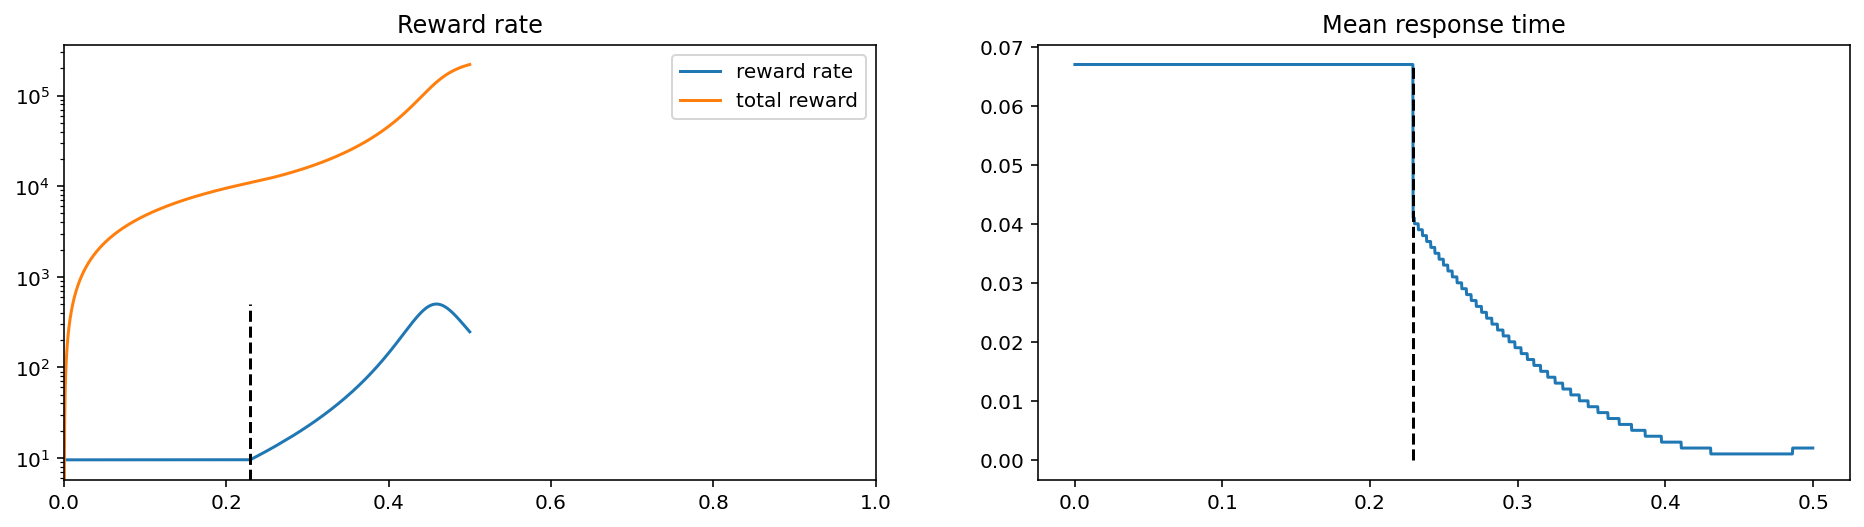

In [29]:
delta_t = [0];
tag = 0
total_reward = [0] 
swap = [x[0] for x in tracking.items() if x[1][0]=='[[1], [0, 2]]'][0]
xx = [learning_rate*x for x in sorted(tracking.keys())]
for i in sorted(tracking.keys()):
    delta_t.append(delta_t[-1] + tracking[i][1][2])
    total_reward.append(total_reward[-1] + tracking[i][1][tag])

fig = plt.figure(figsize=(16,4))

plt.subplot(1, 2, 1)
yy = [tracking[x][1][tag] for x in tracking.keys()]
plt.plot(xx, yy, label='reward rate')
plt.semilogy(xx, total_reward[:-1], label='total reward')
plt.title('Reward rate')
plt.vlines(xx[swap], 0, np.max(yy[:-1]), color='black', linestyles='dashed')
plt.legend()
plt.xlim(0,1)

plt.subplot(1, 2, 2)
yy = [tracking[x][1][2] for x in tracking.keys()]
plt.plot(xx, yy)
plt.title('Mean response time')
plt.vlines(xx[swap], 0, np.max(yy), color='black', linestyles='dashed')


In [31]:
gg = update_path_weight(G, learning_rate*swap, new_path)
list(zip(gg.edges(data=True), G.edges(data=True)))

[((0, 1, {'weight': 6.350816911135614}),
  (0, 1, {'weight': 6.350816911135614})),
 ((1, 2, {'weight': 6.445065326710559}),
  (1, 2, {'weight': 6.445065326710559})),
 ((3, 4, {'weight': 11.249263349017022}),
  (3, 4, {'weight': 11.249263349017022})),
 ((3, 6, {'weight': 0.4496202211705037}),
  (3, 6, {'weight': 1.9616938096444314})),
 ((4, 2, {'weight': 6.107581171039813}),
  (4, 2, {'weight': 6.107581171039813})),
 ((4, 5, {'weight': 11.104387729245513}),
  (4, 5, {'weight': 11.104387729245513})),
 ((6, 5, {'weight': 0.4060375896400178}),
  (6, 5, {'weight': 1.7715427122164824}))]

In [32]:
horizon_iter = 2400 
T_horizon = 2400
tag = -1

In [33]:
### no learning scenario 

no_learning_reward = [0];
no_learning_timeline = [0]

pbar = tqdm(total=T_horizon)
while no_learning_timeline[-1]<T_horizon:
    no_learning_reward.append(no_learning_reward[-1] + full_record[1]['[[2], [0, 1]]'][1])
    no_learning_timeline.append(no_learning_timeline[-1] + full_record[1]['[[2], [0, 1]]'][2])
    pbar.update(full_record[1]['[[2], [0, 1]]'][2])
    
pbar.close()

  0%|          | 0/2400 [00:00<?, ?it/s]

In [34]:
full_record[1]['[[2], [0, 1]]'], full_record[1]['[[0], [1]]']

([9.534, 0.642, 0.067, 1.414, 0.433], [0.284, 1.0, 3.526, 1.0, 0.221])

In [35]:
### always learning scenario 

always_learning_reward = [0];
always_learning_timeline = [0]
learning_step = 1;

pbar = tqdm(total=T_horizon)
while always_learning_timeline[-1]<T_horizon:
    if full_record[learning_step]['[[2], [0, 1]]'][tag]>full_record[learning_step]['[[1], [0, 2]]'][tag]:
        always_learning_reward.append(always_learning_reward[-1] + full_record[learning_step]['[[2], [0, 1]]'][1])
        always_learning_timeline.append(always_learning_timeline[-1] + full_record[learning_step]['[[2], [0, 1]]'][2] + full_record[learning_step]['[[1], [0, 2]]'][2])
        pbar.update(full_record[learning_step]['[[2], [0, 1]]'][2] + full_record[learning_step]['[[1], [0, 2]]'][2]);
    else:
        always_learning_reward.append(always_learning_reward[-1] + full_record[learning_step]['[[1], [0, 2]]'][1])
        always_learning_timeline.append(always_learning_timeline[-1] + full_record[learning_step]['[[1], [0, 2]]'][2])
        pbar.update(full_record[learning_step]['[[1], [0, 2]]'][2])
    learning_step = np.min([learning_step+1, horizon_iter])
pbar.close()

  0%|          | 0/2400 [00:00<?, ?it/s]

In [36]:
###  learning first scenario 

learning_first_reward = [0];
learning_first_timeline = [0]
learning_step = 1;

while learning_first_timeline[-1]<T_horizon:
    if full_record[learning_step]['[[2], [0, 1]]'][tag]>full_record[learning_step]['[[1], [0, 2]]'][tag]:
        learning_first_reward.append(learning_first_reward[-1]+0)
        learning_first_timeline.append(learning_first_timeline[-1] + full_record[learning_step]['[[1], [0, 2]]'][2])
    else:
        learning_first_reward.append(learning_first_reward[-1] + full_record[learning_step]['[[1], [0, 2]]'][1])
        learning_first_timeline.append(learning_first_timeline[-1] + full_record[learning_step]['[[1], [0, 2]]'][2])
    learning_step = np.min([learning_step+1, horizon_iter])

In [37]:
###  random learning scenario 

random_learning_reward = [0];
random_learning_timeline = [0]
learning_step = 1;
p = 0.8

while random_learning_timeline[-1]<T_horizon:
    if np.random.rand()<p:
        random_learning_reward.append(random_learning_reward[-1] + full_record[learning_step]['[[1], [0, 2]]'][1])
        random_learning_timeline.append(random_learning_timeline[-1] + full_record[learning_step]['[[1], [0, 2]]'][2])
        learning_step = np.min([learning_step+1, np.max(list(full_record.keys()))])
    else:
        random_learning_reward.append(random_learning_reward[-1] + full_record[learning_step]['[[2], [0, 1]]'][1])
        random_learning_timeline.append(random_learning_timeline[-1] + full_record[learning_step]['[[2], [0, 1]]'][2])


In [38]:
###  variable learning scenario 

variable_learning_reward = [0];
variable_learning_timeline = [0]
learning_step = 1;
ps = []
while variable_learning_timeline[-1]<T_horizon:
    p = (full_record[learning_step]['[[2], [0, 1]]'][tag] - full_record[learning_step]['[[1], [0, 2]]'][tag])/full_record[learning_step]['[[2], [0, 1]]'][tag]
    if np.random.rand()<p:
        variable_learning_reward.append(variable_learning_reward[-1] + full_record[learning_step]['[[2], [0, 1]]'][1])
        variable_learning_timeline.append(variable_learning_timeline[-1] + full_record[learning_step]['[[2], [0, 1]]'][2])
    else:
        variable_learning_reward.append(variable_learning_reward[-1] + full_record[learning_step]['[[1], [0, 2]]'][1])
        variable_learning_timeline.append(variable_learning_timeline[-1] + full_record[learning_step]['[[1], [0, 2]]'][2])
        learning_step = np.min([learning_step+1, horizon_iter])
    ps.append(p)

In [39]:
### Serial scenario 
serial_reward = [0];
serial_timeline = [0]

pbar = tqdm(total=T_horizon)
while serial_timeline[-1]<T_horizon:
    serial_reward.append(serial_reward[-1] + full_record[1]['[[1], [0]]'][1])
    serial_timeline.append(serial_timeline[-1] + full_record[1]['[[1], [0]]'][2])
    pbar.update(full_record[1]['[[1], [0]]'][2])
    
pbar.close()

  0%|          | 0/2400 [00:00<?, ?it/s]

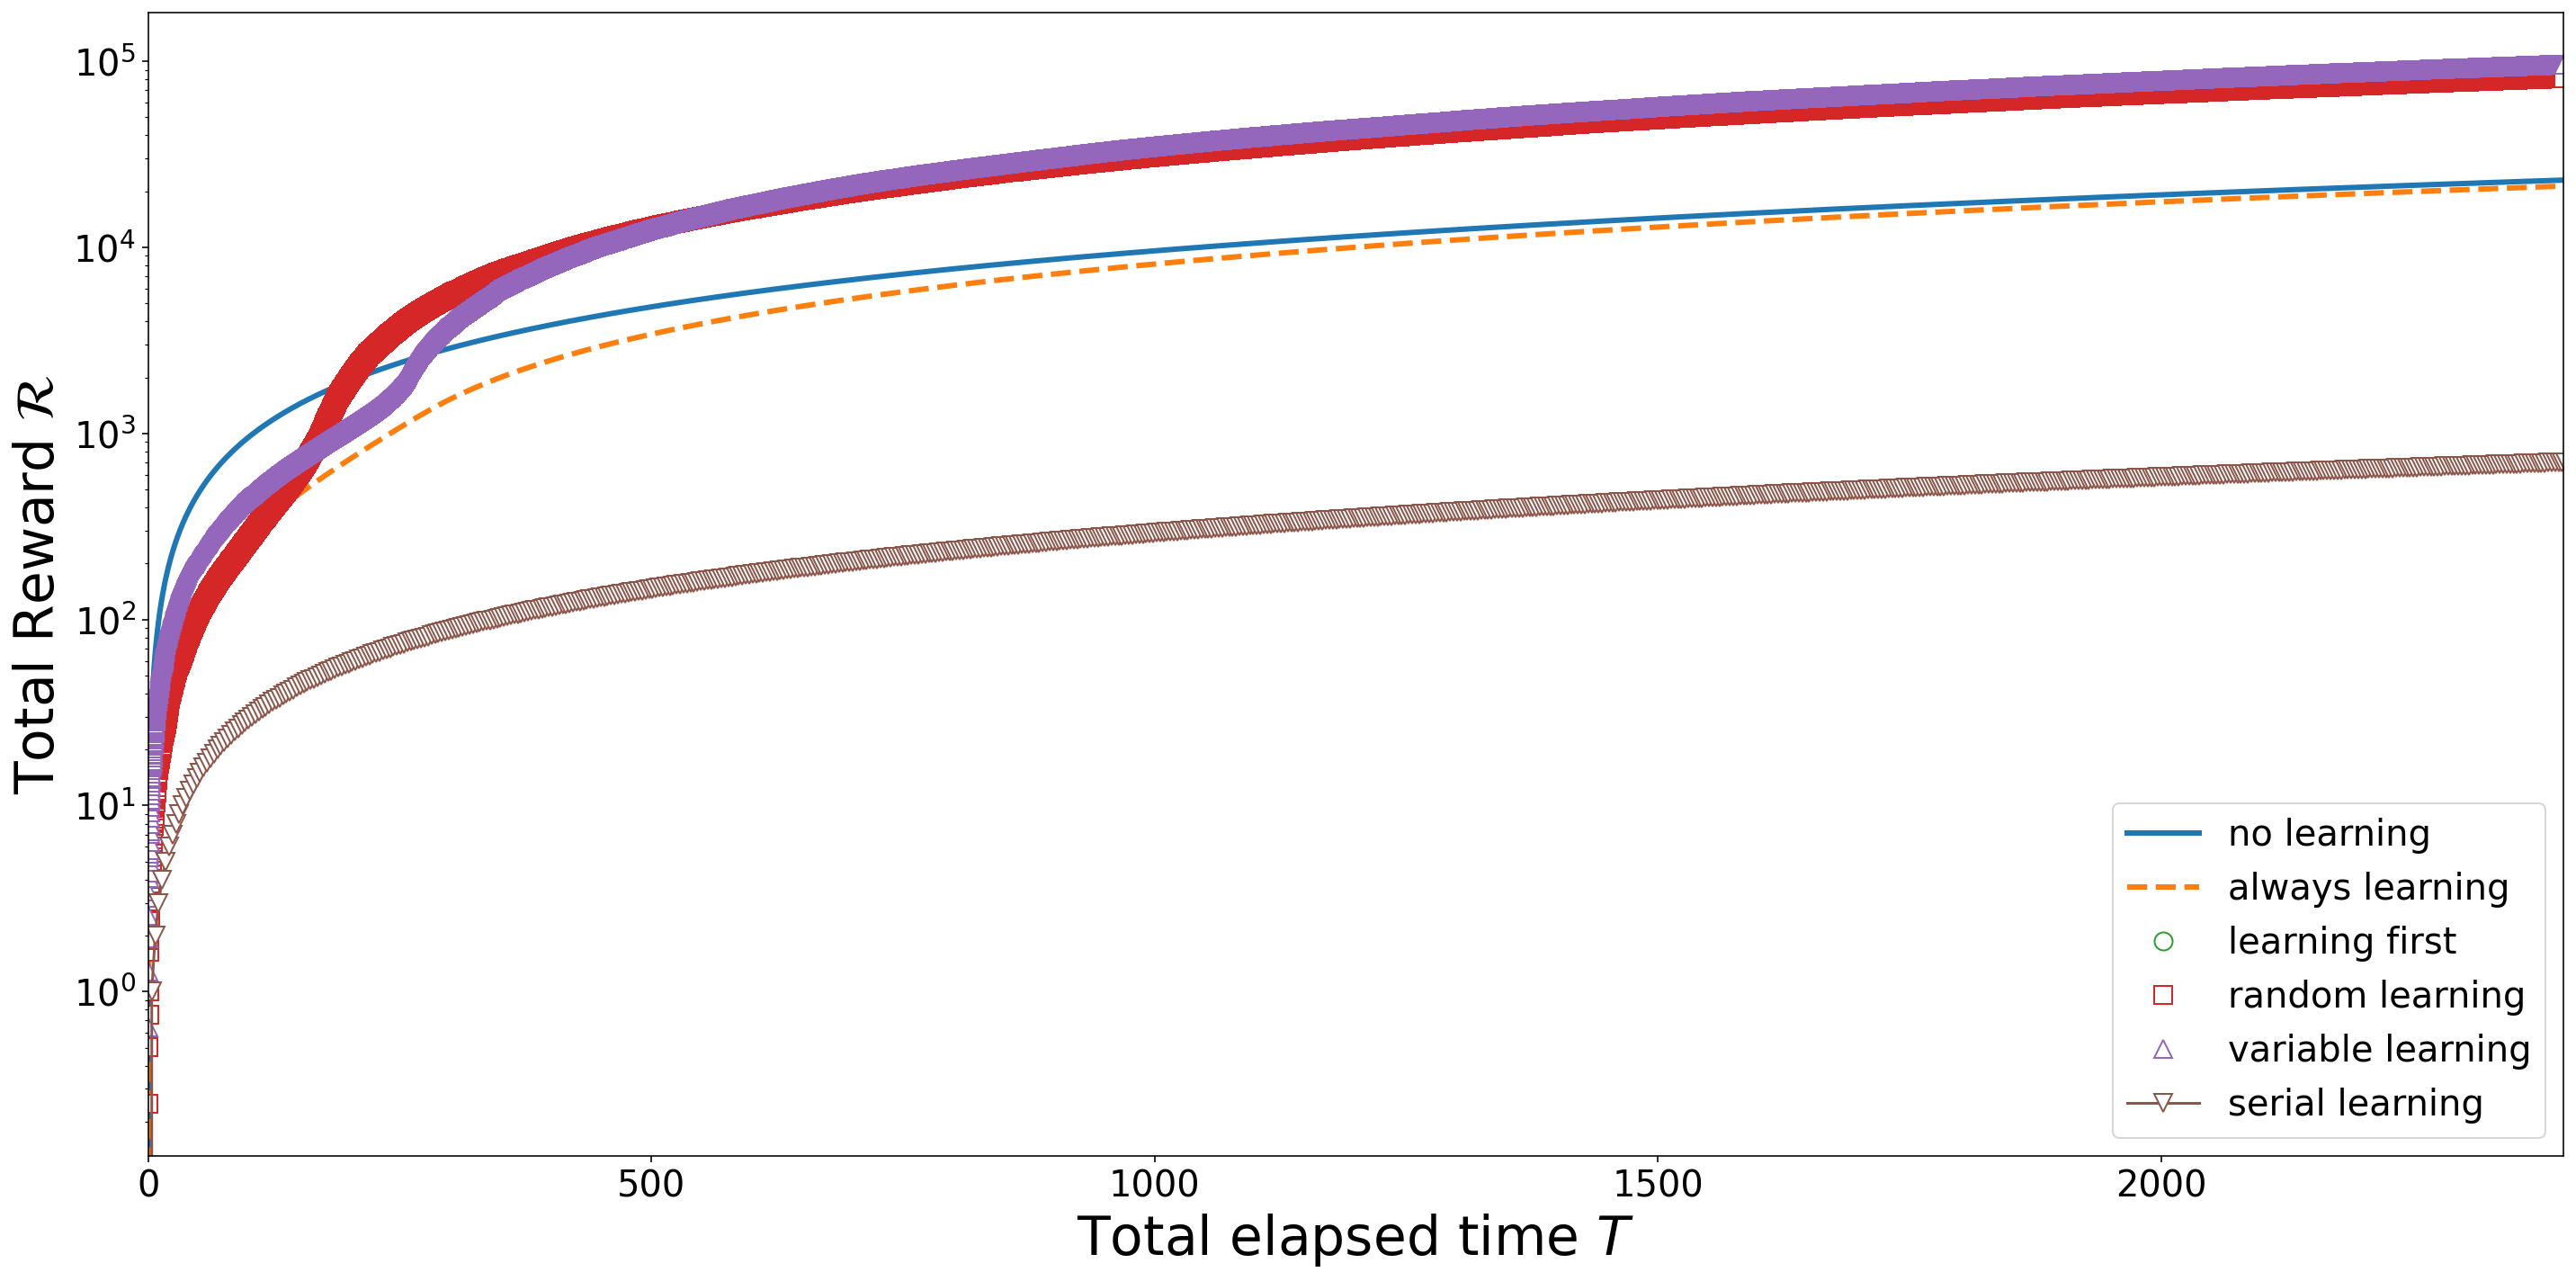

In [40]:
fig = plt.figure(figsize=(20, 10))
subsample = 1
plt.plot(no_learning_timeline, no_learning_reward, "-", lw=3, label="no learning")
plt.plot(
    always_learning_timeline,
    always_learning_reward,
    "--",
    lw=3,
    label="always learning",
)

plt.plot(
    learning_first_timeline[::subsample],
    learning_first_reward[::subsample],
    "o",
    ms=10,
    mfc="white",
    label="learning first",
)
plt.plot(
    random_learning_timeline[::subsample],
    random_learning_reward[::subsample],
    "s",
    ms=10,
    mfc="white",
    label="random learning",
)

plt.plot(
    variable_learning_timeline[::subsample],
    variable_learning_reward[::subsample],
    "^",
    ms=10,
    mfc="white",
    label="variable learning",
)

plt.plot(
    np.array(serial_timeline),
    serial_reward,
    "v-",
    ms=10,
    mfc="white",
    label="serial learning",
)

# plt.xscale('log')
plt.yscale("log")
plt.legend(fontsize=20)
plt.xlim(0, T_horizon)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r"Total Reward $\mathcal{R}$", fontsize=30)
plt.xlabel(r"Total elapsed time $T$", fontsize=30)
plt.tight_layout()


# Policy + discounting 

In [41]:
def projected_reward(policy, T_h, it, t, ft, lambda_=0):
    itt = np.min([it, np.max(list(ft.keys()))-1])
    rt = ft[itt][policy][-1]
    R = rt * (T_h - t) * np.exp(lambda_ * (T_h - t))
    return R; 

def policy_probs(T_h, it, t, ft, lambda_=0, policies=None, epsilon = 0.0001):
    if policies==None:
        policies = ['[[1], [0, 2]]', '[[1], [0]]', '[[2], [0, 1]]'];
    Rs = [epsilon + projected_reward(x, T_h, it, t, ft, lambda_) for x in policies];
    totR = np.sum(Rs);
    return dict(zip(policies, [x/totR for x in Rs]));

def instant_policy(pp):
    k, w = list(pp.keys()), list(pp.values());
    policy_id = np.random.choice(k, 1, p=w)
    return policy_id[0];

def accrue_reward_spent_time(ft, policy, it):
    itt = np.min([it, np.max(list(ft.keys()))-1])
    return ft[itt][policy][1], ft[itt][policy][2]; # 1 is the entry for pure reward 


In [42]:
good_ks = ['Serial', 'new pathway']
ks  = ['[[1], [0]]', '[[1], [0, 2]]']

0it [00:00, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

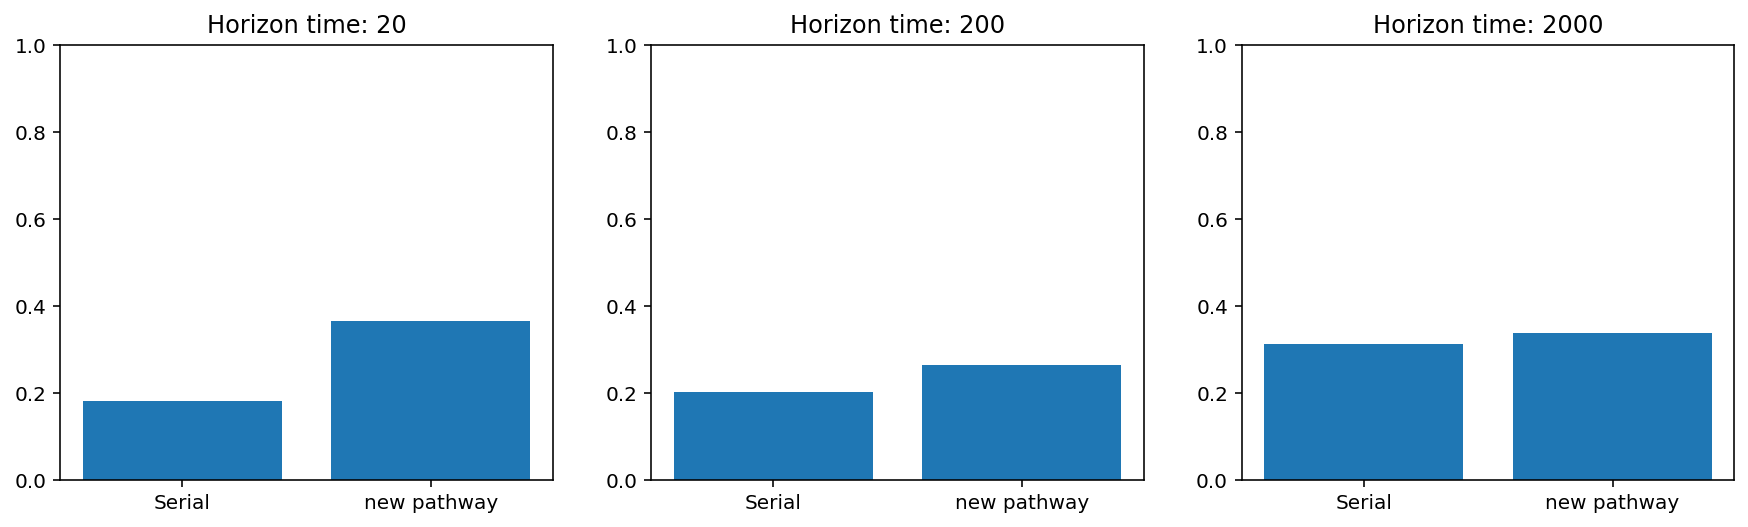

In [45]:
from collections import Counter
T_hs = [20, 200, 2000] #
num_iterations = 300
considered_fraction = 0.5
discount_factor = -.2
lt0 = 1
fig = plt.figure(figsize=(5*len(T_hs), 4))
chosen_policies_dict = {}
max_lts = {}
for j, T_h in tqdm(enumerate(T_hs)):
    chosen_policies_dict[T_h] = []
    max_lts[T_h] = []
    for iteration in tqdm(range(num_iterations)):
        chosen_policies = []
        reward_tracking = [0]
        spent_time = [0]
        lt = lt0
        while spent_time[-1]<T_h:
            probs = policy_probs(T_h, lt, spent_time[-1], full_record, lambda_= discount_factor)
            chosen_policies.append(instant_policy(probs))
            ar, st = accrue_reward_spent_time(full_record, chosen_policies[-1], lt)
            reward_tracking.append(reward_tracking[-1] + ar);
            spent_time.append(spent_time[-1] + st)
            if chosen_policies[-1] == '[[1], [0, 2]]':
                lt+=10;
        max_lts[T_h].append(lt);
        L = int(len(chosen_policies) * considered_fraction)
    chosen_policies_dict[T_h].extend(chosen_policies[-L:])
    plt.subplot(1, len(T_hs), j+1)

    count = Counter(chosen_policies_dict[T_h])

    boxes = [count[x]/len(chosen_policies_dict[T_h]) for x in ks]

    plt.bar(range(len(ks)), boxes) 
    plt.xticks(range(len(ks)), good_ks);
    plt.title('Horizon time: '+str(T_h) )
    plt.ylim(0,1)

0it [00:00, ?it/s]

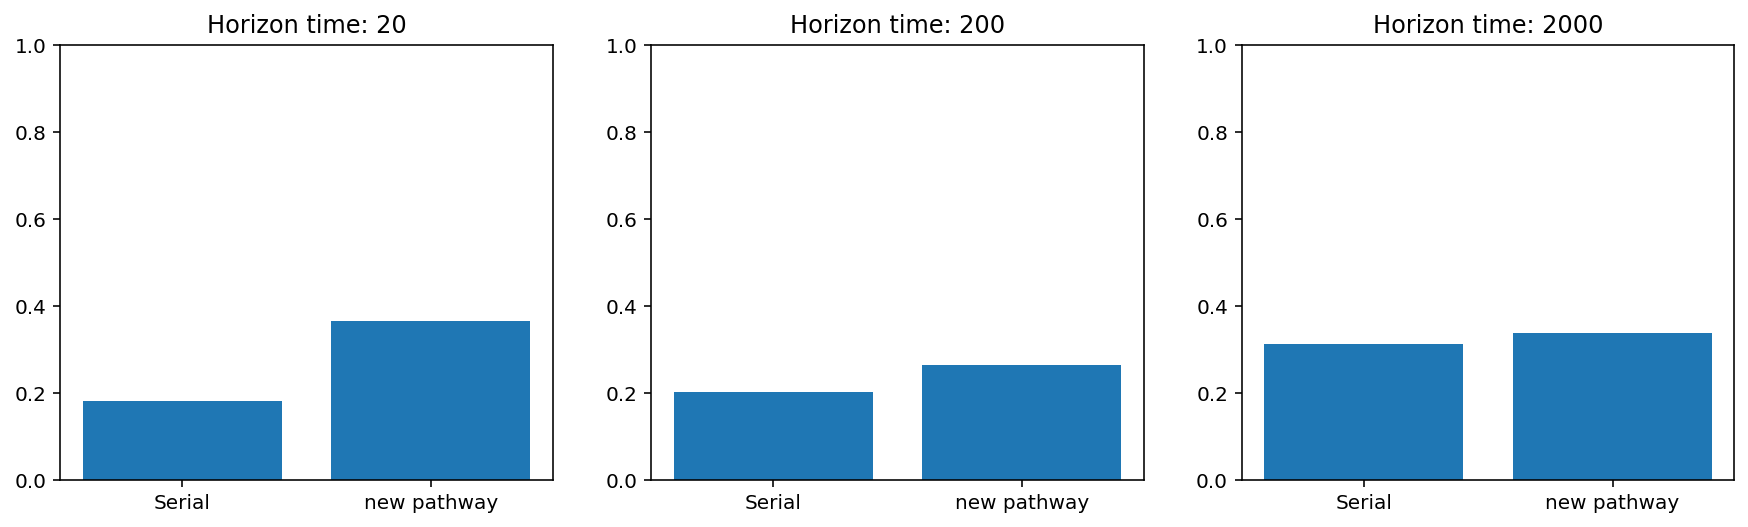

In [46]:
from collections import Counter

fig = plt.figure(figsize=(5*len(T_hs), 4))
for j, T_h in tqdm(enumerate(T_hs)):
    plt.subplot(1, len(T_hs), j+1)

    count = Counter(chosen_policies_dict[T_h])

    boxes = [count[x]/len(chosen_policies_dict[T_h]) for x in ks]

    plt.bar(range(len(ks)), boxes) 
    plt.xticks(range(len(ks)), good_ks);
    plt.title('Horizon time: '+str(T_h) )
    plt.ylim(0,1)

([<matplotlib.axis.XTick at 0x2b39a5910>,
 [Text(0, 0, '20'), Text(1, 0, '200'), Text(2, 0, '2000')])

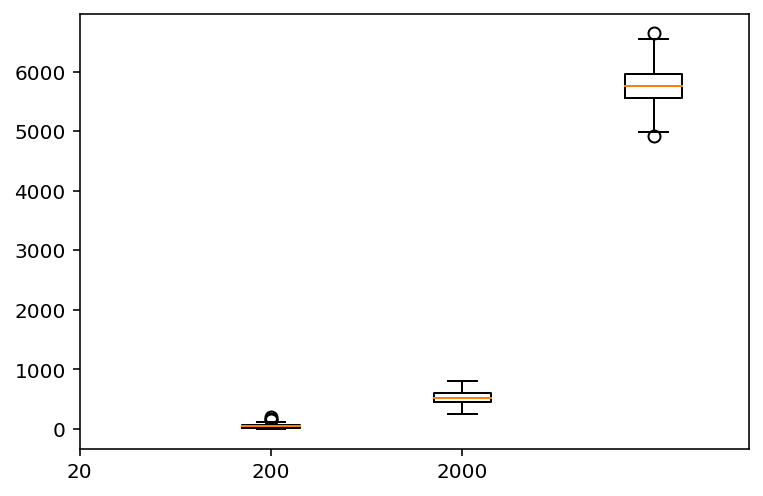

In [49]:
mlk = sorted(max_lts.keys())
plt.boxplot([max_lts[x] for x in mlk]);
plt.xticks(range(len(mlk)), mlk)

# bulk policy exploration 

Bulk optimization was done using the script provided in the repo.

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

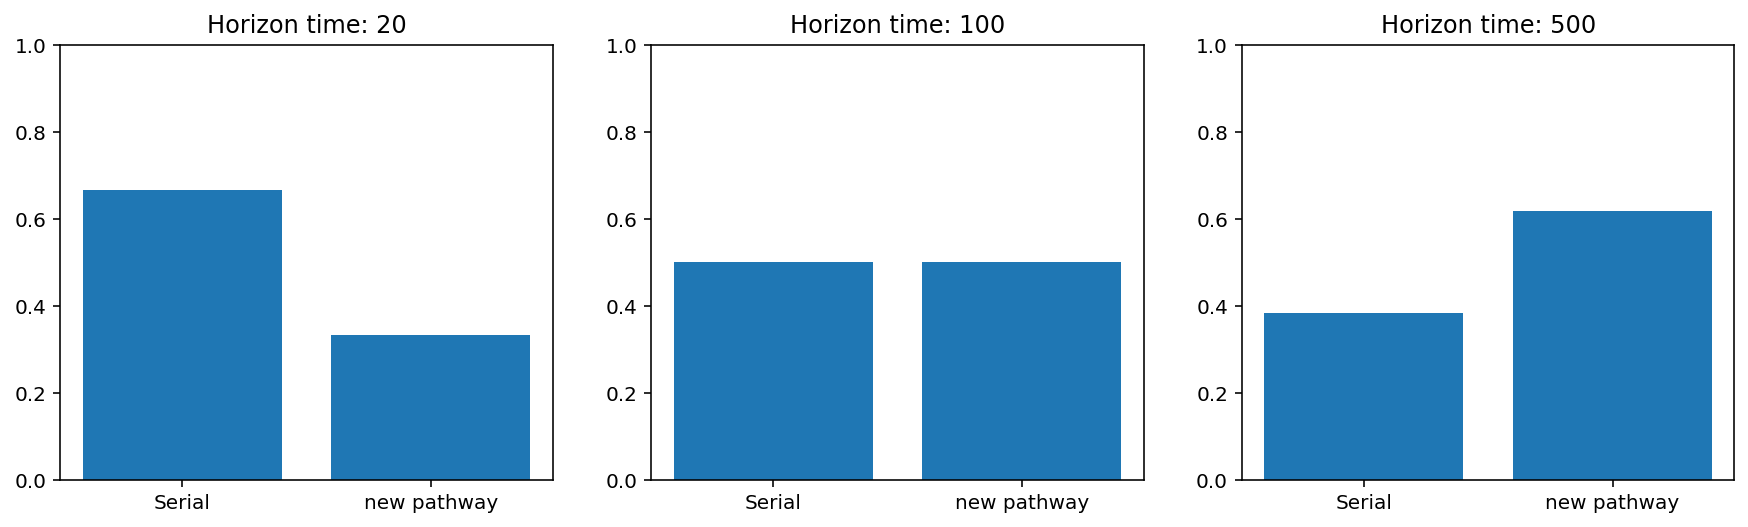

0it [00:00, ?it/s]

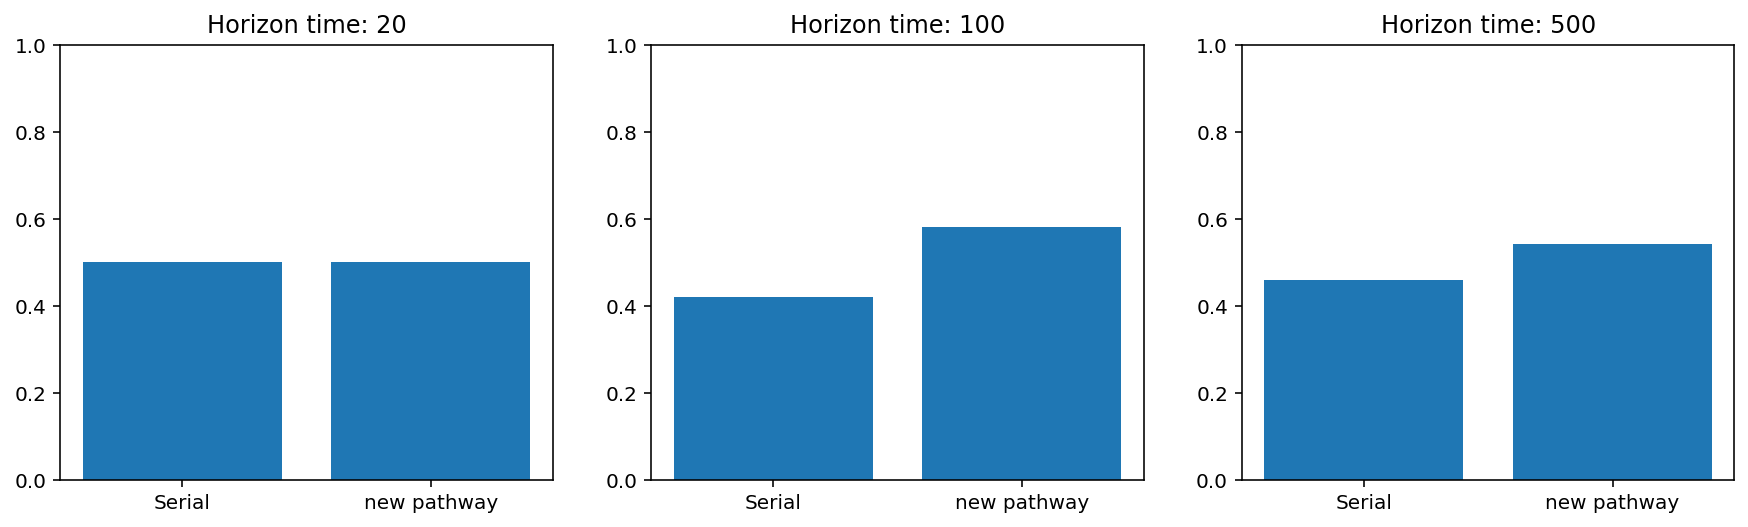

0it [00:00, ?it/s]

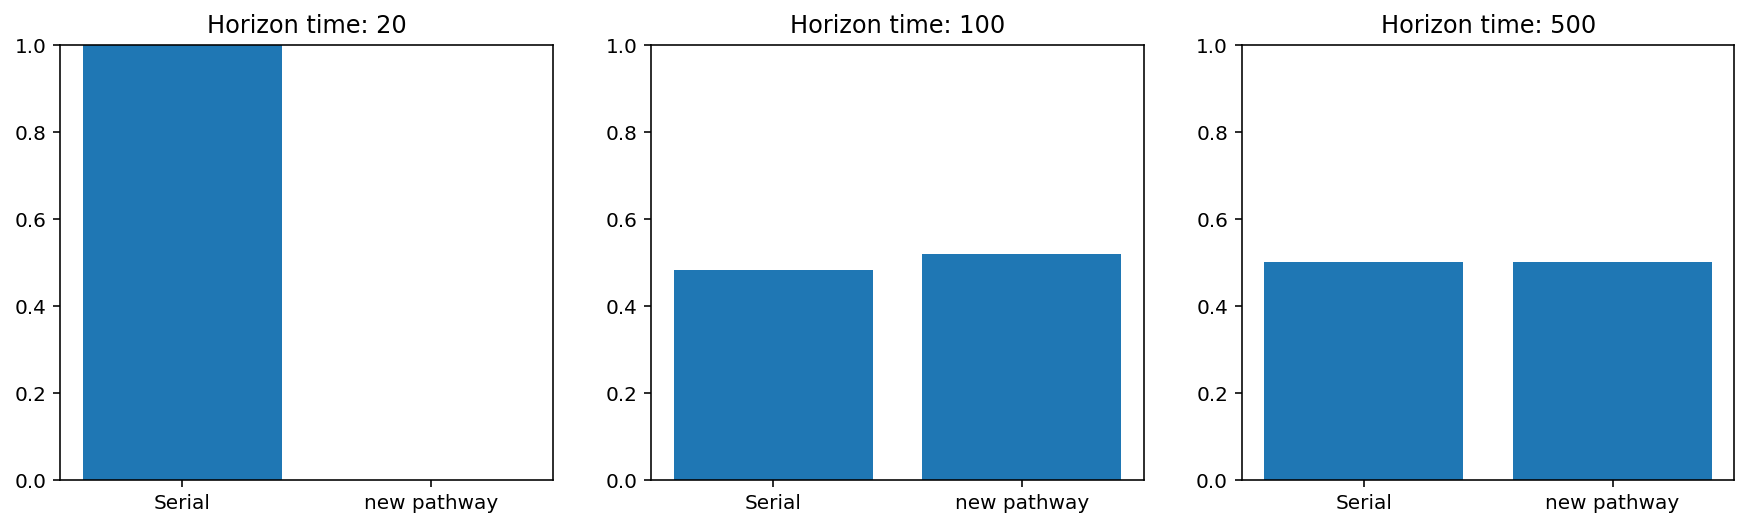

In [57]:
discount_factors = [-0.0, -.2, -.6]
T_hs = [20, 100, 500] #

for discount_factor in tqdm(discount_factors):
    lt0 = 1
    fig = plt.figure(figsize=(5*len(T_hs), 4))
    chosen_policies_dict[discount_factor] = {}
    max_lts = {}
    for j, T_h in tqdm(enumerate(T_hs)):
        chosen_policies_dict[discount_factor][T_h] = []
        max_lts[T_h] = []
        for iteration in range(num_iterations):
            chosen_policies = []
            reward_tracking = [0]
            spent_time = [0]
            lt = lt0
            while spent_time[-1]<T_h:
                probs = policy_probs(T_h, lt, spent_time[-1], full_record, policies=ks, lambda_= discount_factor)
                chosen_policies.append(instant_policy(probs))
                ar, st = accrue_reward_spent_time(full_record, chosen_policies[-1], lt)
                reward_tracking.append(reward_tracking[-1] + ar);
                spent_time.append(spent_time[-1] + st)
                if chosen_policies[-1] == '[[1], [0, 2]]': ##learning ratae
                    lt+=20;
            max_lts[T_h].append(lt);
            L = int(len(chosen_policies) * considered_fraction)
        chosen_policies_dict[discount_factor][T_h].extend(chosen_policies[-L:])
        plt.subplot(1, len(T_hs), j+1)

        count = Counter(chosen_policies_dict[discount_factor][T_h])

        boxes = [count[x]/len(chosen_policies_dict[discount_factor][T_h]) for x in ks]

        plt.bar(range(len(ks)), boxes) 
        plt.xticks(range(len(ks)), good_ks);
        plt.title('Horizon time: '+str(T_h) )
        plt.ylim(0,1)
        
    plt.show()

